<a href="https://colab.research.google.com/github/noviyblock/The-model-classifying-PCB-defects/blob/main/%D0%9A%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%B0%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install keras-tuner
!pip install opencv-python
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [19]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

# Константы
DATA_DIR = '/content/drive/MyDrive/PCB_DATASET/PCB_DATASET'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
SEED = 42

# Список классов дефектов
CLASSES = [
    'Missing_hole',
    'Mouse_bite',
    'Open_circuit',
    'Short',
    'Spur',
    'Spurious_copper'
]
NUM_CLASSES = len(CLASSES)

# Настройки для воспроизводимости
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [20]:
def load_images_and_labels():
    """Загрузка изображений и соответствующих меток"""
    images = []
    labels = []

    for class_idx, class_name in enumerate(CLASSES):
        class_dir = os.path.join(DATA_DIR, 'images', class_name)

        for img_file in os.listdir(class_dir):
            if img_file.endswith('.jpg'):
                # Загрузка изображения
                img_path = os.path.join(class_dir, img_file)
                img = cv2.imread(img_path)

                # Предварительная обработка
                img = cv2.resize(img, IMAGE_SIZE)
                img = img.astype('float32') / 255.0  # Нормализация

                images.append(img)
                labels.append(class_idx)

    return np.array(images), np.array(labels)

def load_data_with_augmentation():
    """Загрузка данных с учетом аннотаций и аугментацией"""
    images, labels = load_images_and_labels()

    # Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels,
        test_size=0.2,
        random_state=SEED,
        stratify=labels
    )

    # Преобразование меток в one-hot encoding
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

    return X_train, X_test, y_train, y_test

# Загрузка данных
X_train, X_test, y_train, y_test = load_data_with_augmentation()
print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Train data shape: (554, 224, 224, 3)
Test data shape: (139, 224, 224, 3)


In [21]:
def create_data_generators(X_train, y_train, X_test, y_test):
    """Создание генераторов данных с аугментацией"""
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    test_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=SEED
    )

    test_generator = test_datagen.flow(
        X_test, y_test,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    return train_generator, test_generator

train_generator, test_generator = create_data_generators(
    X_train, y_train, X_test, y_test
)

In [22]:
def create_model_with_transfer_learning(input_shape, num_classes):
    """Создание модели с использованием transfer learning"""
    # Используем EfficientNetB0 в качестве базовой модели
    base_model = applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )

    # Замораживаем веса предобученной модели
    base_model.trainable = False

    # Создаем новую модель поверх базовой
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    # Компиляция модели
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Создание модели
input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
model = create_model_with_transfer_learning(input_shape, NUM_CLASSES)
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,379,049 (16.70 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [23]:
def train_model(model, train_generator, test_generator):
    """Функция для обучения модели"""
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=7,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.h5',
            save_best_only=True,
            monitor='val_accuracy',
            mode='max'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6,
            verbose=1
        )
    ]

    # Обучение модели
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=EPOCHS,
        validation_data=test_generator,
        validation_steps=len(test_generator),
        callbacks=callbacks,
        verbose=1
    )

    return history

history = train_model(model, train_generator, test_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1581 - loss: 1.8836

18/18 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.1581 - loss: 1.8837 - val_accuracy: 0.1655 - val_loss: 1.8080 - learning_rate: 0.0010
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.1882 - loss: 1.8574 - val_accuracy: 0.1655 - val_loss: 1.7944 - learning_rate: 0.0010
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.1764 - loss: 1.8211 - val_accuracy: 0.1655 - val_loss: 1.7942 - learning_rate: 0.0010
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.1624 - loss: 1.8157 - val_accuracy: 0.1655 - val_loss: 1.7952 - learning_rate: 0.0010
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.1377 - loss: 1.8093 - val_accuracy: 0.1655 - val_loss: 1.7917 - learning_rate: 0.0010
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.1709 - loss: 1.7912 - val_accuracy: 0.1655 - val_loss: 1.7937 - learning_rate: 0.0010
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.1725 - loss: 1.8071 - val_accuracy: 0.1655 - va

5/5 - 17s - 3s/step - accuracy: 0.1655 - loss: 1.7934

Test accuracy: 0.1655
Test loss: 1.7934


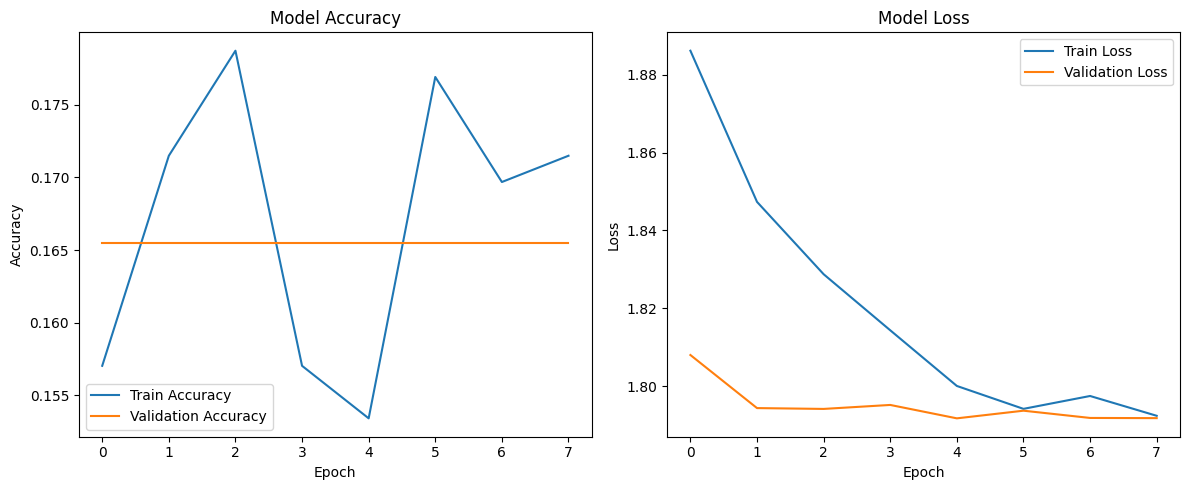

In [24]:
def evaluate_model(model, test_generator):
    """Оценка модели на тестовых данных"""
    # Загрузка лучшей версии модели
    model = tf.keras.models.load_model('best_model.h5')

    # Оценка на тестовых данных
    test_loss, test_acc = model.evaluate(test_generator, verbose=2)
    print(f"\nTest accuracy: {test_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}")

    return test_acc, test_loss

def plot_training_history(history):
    """Визуализация процесса обучения"""
    plt.figure(figsize=(12, 5))

    # График точности
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # График потерь
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Оценка и визуализация
test_acc, test_loss = evaluate_model(model, test_generator)
plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


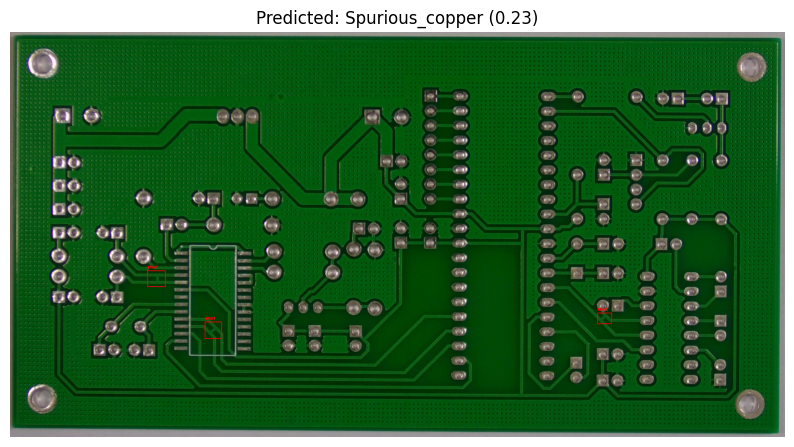

In [25]:
def predict_defect(image_path, model):
    """Предсказание типа дефекта для одного изображения"""
    # Загрузка и предобработка изображения
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image from {image_path}")

    img = cv2.resize(img, IMAGE_SIZE)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)  # Добавляем размерность батча

    # Предсказание
    predictions = model.predict(img)
    class_idx = np.argmax(predictions[0])
    confidence = predictions[0][class_idx]

    return CLASSES[class_idx], confidence

def parse_annotation(xml_path):
    """Парсинг XML аннотаций для получения информации о дефектах"""
    tree = ET.parse(xml_path)
    root = tree.getroot()

    objects = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        objects.append({
            'name': name,
            'bbox': [xmin, ymin, xmax, ymax]
        })

    return objects

def visualize_prediction(image_path, model):
    """Визуализация изображения с предсказанием"""
    # Предсказание
    defect_type, confidence = predict_defect(image_path, model)

    # Загрузка изображения для визуализации
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Получение соответствующего XML файла
    xml_path = image_path.replace('images', 'Annotations').replace('.jpg', '.xml')
    if os.path.exists(xml_path):
        annotations = parse_annotation(xml_path)
        for ann in annotations:
            xmin, ymin, xmax, ymax = ann['bbox']
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
            cv2.putText(img, ann['name'], (xmin, ymin-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Отображение результатов
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.title(f"Predicted: {defect_type} ({confidence:.2f})")
    plt.axis('off')
    plt.show()

# Пример использования
test_image_path = os.path.join(DATA_DIR, 'images', 'Short', '01_short_01.jpg')
visualize_prediction(test_image_path, model)

In [26]:
def fine_tune_model(model, train_generator, test_generator):
    """Тонкая настройка модели после transfer learning"""
    # Размораживаем верхние слои базовой модели
    model.layers[1].trainable = True

    # Перекомпилируем модель с меньшей скоростью обучения
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Дополнительное обучение
    fine_tune_epochs = 10
    total_epochs = EPOCHS + fine_tune_epochs

    history_fine = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=total_epochs,
        initial_epoch=history.epoch[-1],
        validation_data=test_generator,
        validation_steps=len(test_generator),
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(
                'fine_tuned_model.h5',
                save_best_only=True,
                monitor='val_accuracy'
            )
        ]
    )

    return history_fine

# Раскомментируйте для выполнения fine-tuning
# history_fine = fine_tune_model(model, train_generator, test_generator)
# plot_training_history(history_fine)

Тестирование модели на различных типах дефектов:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


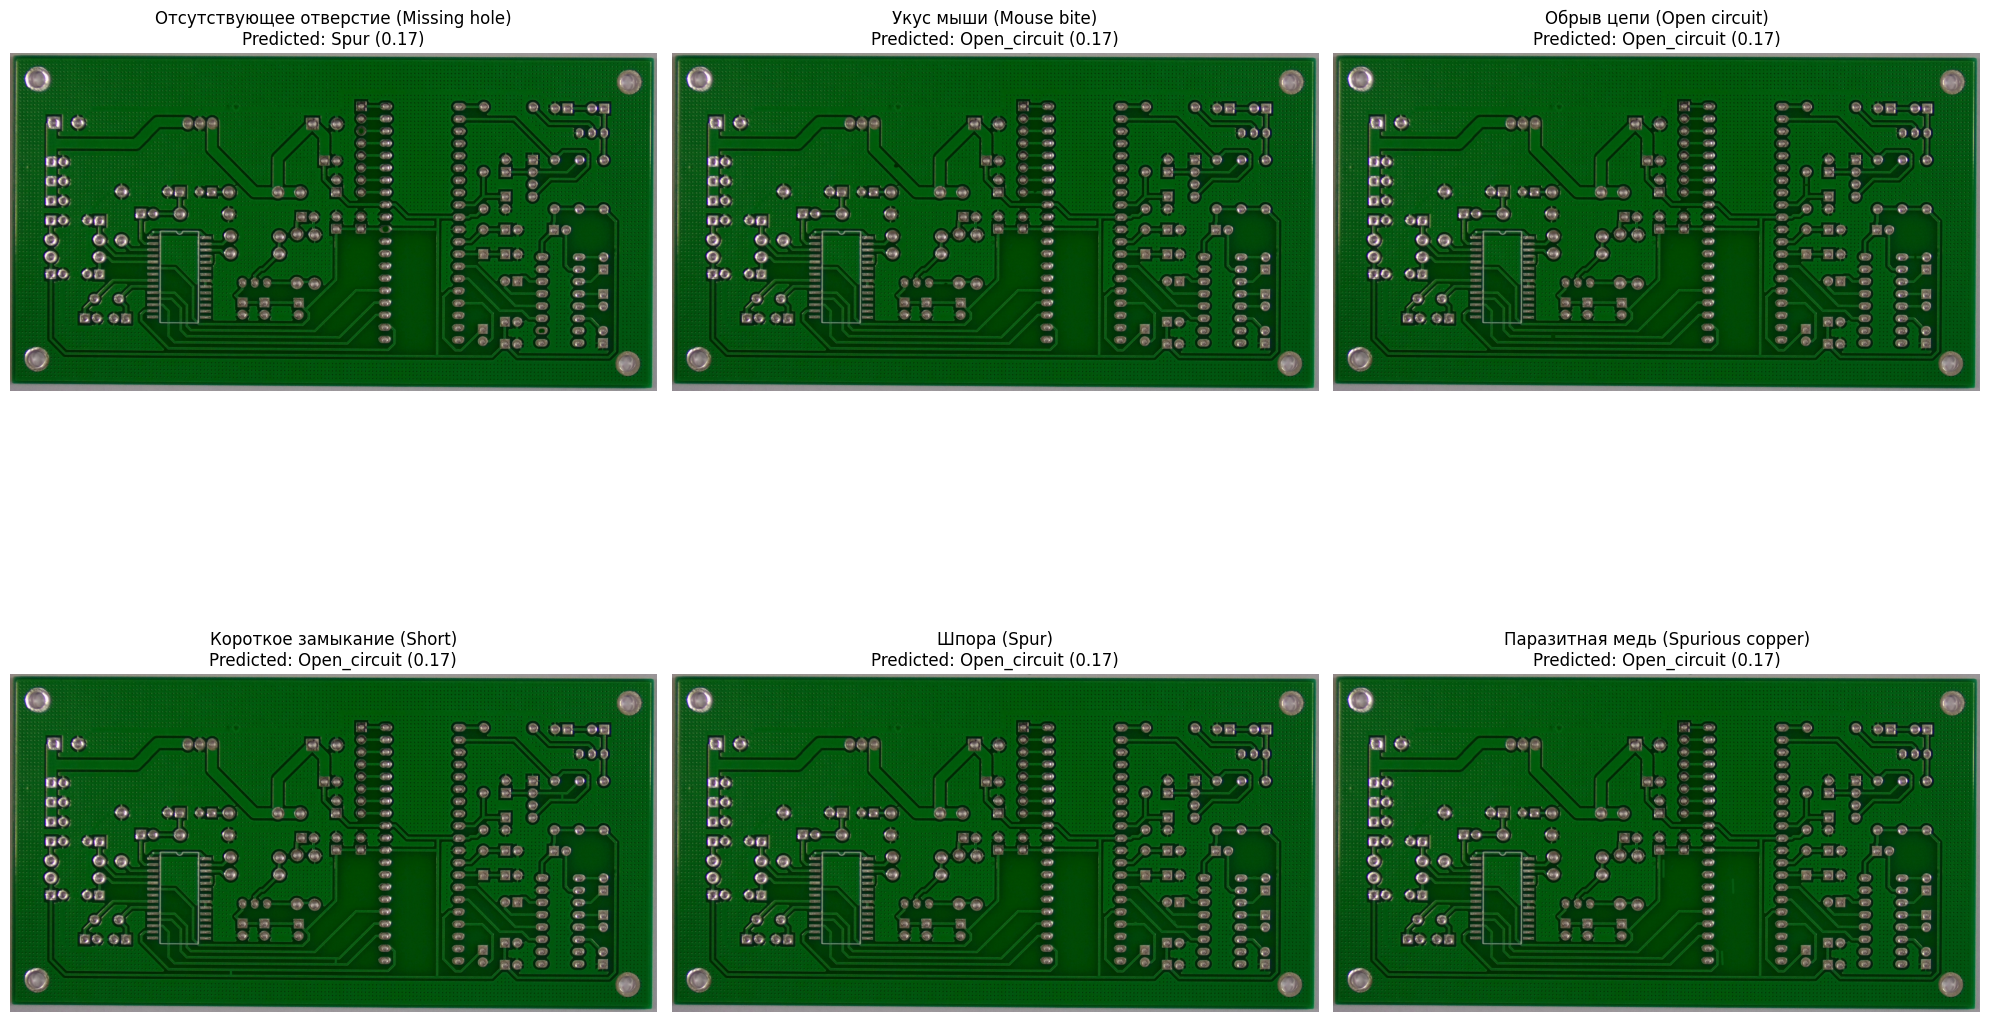

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step

Дефект: Отсутствующее отверстие (Missing hole)
Предсказание: Spur (уверенность: 16.92%)
Аннотации:
- missing_hole at [2459, 1274, 2530, 1329]
- missing_hole at [1613, 334, 1679, 396]
- missing_hole at [1726, 794, 1797, 854]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step

Дефект: Укус мыши (Mouse bite)
Предсказание: Open_circuit (уверенность: 16.95%)
Аннотации:
- mouse_bite at [1019, 500, 1079, 558]
- mouse_bite at [1264, 1067, 1301, 1100]
- mouse_bite at [1683, 638, 1723, 677]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step

Дефект: Обрыв цепи (Open circuit)
Предсказание: Open_circuit (уверенность: 16.96%)
Аннотации:
- open_circuit at [2204, 604, 2236, 641]
- open_circuit at [1015, 1312, 1050, 1349]
- open_circuit at [2713, 946, 2746, 979]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

Дефект: Короткое замыкание (Short)
Предсказание: Open_circuit (уверенность: 16.98%)
Аннотации:
- short at [1010, 1371, 1065, 1418]
- short at [2560, 556, 2618, 596]
- short at [1500, 1326, 

In [39]:
# Блок дополнительных тестовых примеров
def test_examples(model):
    test_images = [
        {
            'path': os.path.join(DATA_DIR, 'images', 'Missing_hole', '01_missing_hole_01.jpg'),
            'title': "Отсутствующее отверстие (Missing hole)"
        },
        {
            'path': os.path.join(DATA_DIR, 'images', 'Mouse_bite', '01_mouse_bite_03.jpg'),
            'title': "Укус мыши (Mouse bite)"
        },
        {
            'path': os.path.join(DATA_DIR, 'images', 'Open_circuit', '01_open_circuit_05.jpg'),
            'title': "Обрыв цепи (Open circuit)"
        },
        {
            'path': os.path.join(DATA_DIR, 'images', 'Short', '01_short_02.jpg'),
            'title': "Короткое замыкание (Short)"
        },
        {
            'path': os.path.join(DATA_DIR, 'images', 'Spur', '01_spur_04.jpg'),
            'title': "Шпора (Spur)"
        },
        {
            'path': os.path.join(DATA_DIR, 'images', 'Spurious_copper', '01_spurious_copper_03.jpg'),
            'title': "Паразитная медь (Spurious copper)"
        }
    ]

    plt.figure(figsize=(20, 15))
    for i, example in enumerate(test_images, 1):
        # Предсказание
        defect_type, confidence = predict_defect(example['path'], model)

        # Загрузка изображения
        img = cv2.imread(example['path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Отображение
        plt.subplot(2, 3, i)
        plt.imshow(img)
        plt.title(f"{example['title']}\nPredicted: {defect_type} ({confidence:.2f})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Дополнительная информация по каждому примеру
    for example in test_images:
      defect_type, confidence = predict_defect(example['path'], model)
      xml_path = example['path'].replace('images', 'Annotations').replace('.jpg', '.xml')

      if os.path.exists(xml_path):
        annotations = parse_annotation(xml_path)
        print(f"\nДефект: {example['title']}")
        print(f"Предсказание: {defect_type} (уверенность: {confidence:.2%})")
        print("Аннотации:")
        for ann in annotations:
            print(f"- {ann['name']} at {ann['bbox']}")
      else:
        print(f"\nДефект: {example['title']}")
        print(f"Предсказание: {defect_type} (уверенность: {confidence:.2%})")
        print("Аннотации не найдены")

# Запуск тестовых примеров
print("Тестирование модели на различных типах дефектов:")
test_examples(model)